# Cats and Dogs: Transferência de Aprendizado

Serão apresentadas as técnicas de *transfer learning* e *fine tunning*. Elas consistem em
utilizar uma rede vencedora da competição anual ImageNet, tanto sua arquitetura como seus
parâmetros treinados em uma outra aplicação envolvendo imagens.

A ideia consiste em utilizar as camadas convolucionais da rede vencedora e trocar apenas as
camadas densas. Num primeiro momento, treina-se apenas as camadas densas (*transfer learning*)
e após este treinamento inicial, continua-se o treinamento com as camadas densas e 
algumas últimas camadas convolucionais da rede (*fine tuning*)

Neste notebook utilizam-se as camadas convolucionais de uma rede ResNet já treinada para gerar as "características" das imagens e treina-se com uma rede neural densa de duas camadas. 

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
from IPython import display

import os, glob
import PIL.Image

import numpy as np
import torch
from torch import nn
import torch.nn.functional as F
import torch.utils.data
import torch.optim.lr_scheduler
import torchvision
from torchvision import transforms
from torchvision import datasets

from lib import pytorch_trainer_v2 as ptt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU available:', device)

GPU available: cpu


## Dataset

In [20]:
batch_size = 50
rootdir = '/data/datasets/catsdogs_fewsamples'
size_final = (224, 224)
transform_noaug = transforms.Compose(
            [transforms.Resize(size=size_final),
             transforms.ToTensor(),
             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

dataset_train = datasets.ImageFolder(rootdir + '/train/', transform = transform_noaug)
dataset_valid = datasets.ImageFolder(rootdir + '/validation/',transform = transform_noaug)

loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=4)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False, num_workers=4)


## Data Loader

In [21]:
#loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=len(dataset_train), shuffle=True)
#loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=len(dataset_valid), shuffle=False)
#x_train, y_train = next(iter(loader_train))
#x_valid, y_valid = next(iter(loader_valid))

## Construção da rede neural
O *transfer learning* permite que utilizemos uma rede já treinada (a *ResNet34*, utilizando apenas uma parte convolucional da rede) para gerar um vetor de features. Essa primeira parte do modelo será chamado de *MyResNetConv*.

É possível utilizar esse vetor de features como entrada de uma rede densa simples, que terá como *output* a saída que será comparada com o resultado desejado. Essa parte final do modelo será chamada de *MyResNetDens*.

Essas duas partes serão integradas no modelo *MyResNet*, com o benefício de podermos utilizar a primeira parte para gerar as *features* convolucionais, que serão utilizadas no treinamento exclusivo da segunda parte.

In [24]:
model_tl = torchvision.models.resnet18(pretrained=True)
for param in model_tl.parameters():
    param.requires_grad = False
    
num_ftrs = model_tl.fc.in_features
model_tl.fc = nn.Linear(num_ftrs, 2)

model_tl = model_tl.to(device)


### Modelos: mrn_conv, mrn_dens e o model básico

São criadas duas classes: rede convolucional e da rede densa.
A classe MyResNet instancia as duas classes referente às redes convolucional e densa.
Dessa forma é possível treinar as redes separadamente e chamá-las diretamente pela
rede principal.

A codificação da rede ResNet está disponível em:
https://github.com/pytorch/vision/blob/master/torchvision/models/resnet.py

## Testando o predict: mrn_conv, mrn_dens e model

In [26]:
x_train, y_train = next(iter(loader_train))
y = model_tl(x_train[:1].to(device))
y

tensor([[0.2550, 0.1197]], grad_fn=<ThAddmmBackward>)

## Treinamento da camada densa utilizando as *features*: mrn_dens

In [27]:
n_epochs = 10
optm = torch.optim.Adam(params=model_tl.parameters())
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_features_catsdogs', reset=True, verbose=1)

trainer_tl = ptt.DeepNetTrainer(model         = model_tl,
                                criterion     = nn.CrossEntropyLoss(),
                                optimizer     = optm,
                                lr_scheduler  = schd,
                                callbacks     = [ptt.AccuracyMetric(), 
                                                ptt.PrintCallback(), 
                                                cb_chkpt],
                                devname       = device)

In [ ]:
train = True
if train:
    trainer_tl.fit_loader(n_epochs   = n_epochs,
                          train_data = loader_train,
                          valid_data = loader_valid,
                          )
else:
    trainer_dens.load_state('/data/models/transferlearning_features_catsdogs')

Start training for 10 epochs


In [14]:
def show_history(trainer):
    idx = np.argmin(trainer.metrics['valid']['losses'])
    idx = min(idx, len(trainer.metrics['valid']['acc']) - 1)
    fig = plt.figure(figsize=(10, 4), dpi=100)
    ax = fig.add_subplot(1, 2, 1)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['losses']))
    ax.plot(a_epochs, trainer.metrics['train']['losses'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['losses']))
    ax.plot(a_epochs, trainer.metrics['valid']['losses'], label='validation')
    ax.set_title('best validation loss: {:.2f}'.format(trainer.metrics['valid']['losses'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['losses'][idx], 'kx')
    ax.legend()
    ax.grid(True)

    ax = fig.add_subplot(1, 2, 2)
    a_epochs = np.arange(1, 1 + len(trainer.metrics['train']['acc']))
    ax.plot(a_epochs, trainer.metrics['train']['acc'], label='training')
    a_epochs = np.arange(1, 1 + len(trainer.metrics['valid']['acc']))
    ax.plot(a_epochs, trainer.metrics['valid']['acc'], label='validation')
    ax.set_title('best loss\' validation accuracy: {:.2f}'.format(trainer.metrics['valid']['acc'][idx]))
    ax.plot(idx + 1, trainer.metrics['valid']['acc'][idx], 'kx')
    ax.legend()
    ax.grid(True)
    plt.show()

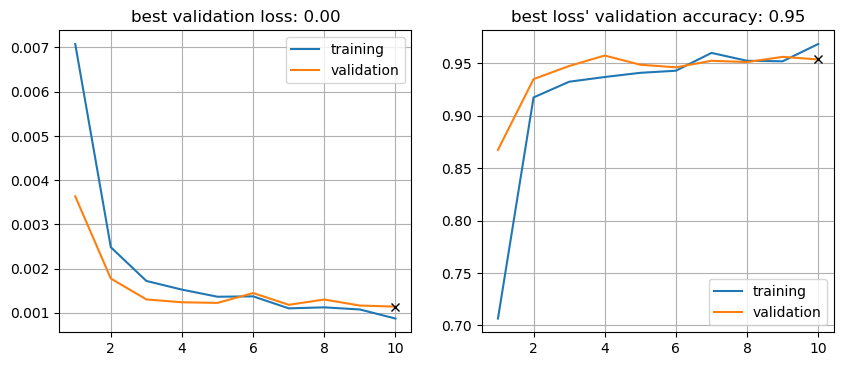

In [15]:
show_history(trainer_dens)

## Fine tunning
É possível ainda refazer o treinamento da camada densa junto com a parte convolucional da rede *ResNet*, utilizando um *learning rate* com valor bem baixo.

In [16]:
for param in model.parameters():
    param.requires_grad = True

## Agora os dados de entrada são os dados originais. Criando os loaders

In [17]:
batch_size = 200
loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

## Preparando para treinar

In [18]:
n_epochs = 5
optm = torch.optim.Adam(params=model.parameters(),  lr=1.e-4)
schd = torch.optim.lr_scheduler.StepLR(optm, step_size=10, gamma=0.75)
cb_chkpt = ptt.ModelCheckpoint('../../models/transferlearning_finetunning_catsdogs', 
                               reset=True, verbose=1)

trainer_finetunning = ptt.DeepNetTrainer(model         = model,
                                         criterion     = nn.CrossEntropyLoss(),
                                         optimizer     = optm,
                                         lr_scheduler  = schd,
                                         callbacks = [ptt.AccuracyMetric(), 
                                                      ptt.PrintCallback(),
                                                      cb_chkpt])

In [22]:
#train = False
#if train:
#    trainer_finetunning.fit_loader(n_epochs, loader_train, loader_valid)
#else:
#    trainer_finetunning.load_state('/data/models/transferlearning_finetunning_catsdogs')

Resultado do treinamento em GPU 1080:

    Start training for 5 epochs
      1:  10.2s   T: 0.10348 0.95750   V: 0.08778 0.96125 best
      2:  10.2s   T: 0.01205 0.99800   V: 0.06722 0.97375 best
      3:  10.2s   T: 0.00294 1.00000   V: 0.09732 0.96500 
      4:  10.2s   T: 0.00121 1.00000   V: 0.06344 0.97625 best
      5:  10.3s   T: 0.00077 1.00000   V: 0.06478 0.98125 
    Stop training at epoch: 5/5
    Best model was saved at epoch 4 with loss 0.06344: ../../models/transferlearning_finetunning_catsdogs

In [23]:
#show_history(trainer_finetunning)

In [24]:
#trainer_finetunning.load_state('/data/models/transferlearning_finetunning_catsdogs')
#acc = trainer_finetunning.evaluate_loader(loader_valid,
#                                    metrics=[ptt.AccuracyMetric()])
#
#print('acc:',acc)

## Exercícios

1. Veja a codificação da rede ResNet (veja o link no github) e explique a inicialização
   da classe do modelo: `super().__init__(BasicBlock, [3, 4, 6, 3])`
2. Observe que a camada densa (`fc`) da ResNet foi suprimida (`del self.fc`). Qual é a
   implicação caso ela não fosse removida? Experimente.
3. Qual é a célula deste notebook que inicializa os pesos de todas as redes?
4. Quantos parâmetros são treinados durante o *transfer learning* da primeira etapa?

## Atividade

1. Utilize a rede ResNet18 e a ResNet50 para fazer o *transfer learning*. 
   Compare os resultados.

## Aprendizados com este notebook
